In [1]:
import cv2
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trackpy as tp
import pandas as pd
import pims
import matplotlib.cm as cm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load the video
cap = cv2.VideoCapture('f_30rotors_5wt_1.3T_5mm_high_50fps_0-150s.mp4')
num_rotor = 30
size_thresh = 25

features = pd.DataFrame(columns=['x', 'y', 'frame'])

# Define the threshold values for different frame ranges if needed
threshold_values = {
    (5983, 5984): (80, 20),
    (5985, 5991): (80, 10),
    (5992, 5993): (80, 10),
    (5994, 5999): (80, 10),
    (6000, 6000): (60, 15),
    (6727, 6730): (80, 15),
    (6731, 6731): (60, 10),
    (6732, 6732): (55, 15),
    (6734, 6737): (70, 15),
    (6741, 6752): (100, 15)
}

frame_num = 0

In [3]:
while True:
    # Read the frame
    ret, frame = cap.read()
    if not ret: break
    # Crop size
    # frame = frame[360:-390, 380:-370] #OG
    frame = frame[360:-330, 380:-370]
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Determine the threshold value based on the frame number
    for frame_range, (threshold_value, size_thresh) in threshold_values.items():
        # print(f"{frame_range=} || {threshold_value=} || {size_thresh=}")
        start_frame, end_frame = frame_range
        if start_frame <= frame_num <= end_frame:
            break
    else:
        # If the frame number is not in any defined range, use a default threshold value
        threshold_value = 150
        size_thresh = size_thresh
        
#     threshold_value = 100
#     size_thresh = size_thresh

    # Threshold the frame to get the white dots
    ret, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    thresh = cv2.GaussianBlur(thresh, (3, 3), 0)

    # Erode the image to remove small noise
    # kernel = np.ones((3,3),np.uint8)
    # thresh = cv2.erode(thresh,kernel,iterations=1)

    # Find connected components in the thresholded frame
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    j = 0
    
    # Iterate through each component and find the centroid
    for i in range(1, num_labels):
        # Check if the size of the component is greater than the threshold
        if stats[i, cv2.CC_STAT_AREA] > size_thresh:
            cx = int(centroids[i][0])
            cy = int(centroids[i][1])
            features = pd.concat([features,pd.DataFrame({'x': [cx], 'y': [cy], 'frame': [frame_num]})],ignore_index=True)
            # Draw a hollow circle at the centroid with a diameter of 10 pixels
            cv2.circle(frame, (cx, cy), 15, (0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            j += 1
    
    print(f"\rFrame {frame_num}", end='', flush=True)
    if j < num_rotor or j > num_rotor:
        print(':', j)
    # Display the frame with the centroids
    # cv2.imshow('frame', frame)
    # cv2.waitKey(0)
    
    if cv2.waitKey(1) == ord('q'):
        break
        
    frame_num += 1

# Release the video and close all windows
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Frame 61: 29
Frame 62: 29
Frame 84: 29
Frame 90: 29
Frame 91: 29
Frame 98: 29
Frame 106: 29
Frame 110: 31
Frame 115: 29
Frame 171: 29
Frame 361: 31
Frame 387: 29
Frame 388: 29
Frame 389: 29
Frame 904: 31
Frame 2651: 31
Frame 4626: 31
Frame 4651: 29
Frame 4665: 29
Frame 4666: 29
Frame 4680: 29
Frame 4681: 29
Frame 4740: 29
Frame 5734: 29
Frame 5735: 29
Frame 5985: 31
Frame 5994: 31
Frame 6000: 32
Frame 6236: 29
Frame 6237: 29
Frame 6238: 29
Frame 6239: 29
Frame 6240: 29
Frame 6241: 29
Frame 6731: 31
Frame 6735: 31
Frame 7050: 29
Frame 7499

-1

Frame 7499: 30 trajectories present.


,x,y,frame,particle
0,169,89,0,0
29,216,165,0,1
28,198,164,0,2
27,184,161,0,3
26,167,160,0,4


<Figure size 600x600 with 0 Axes>

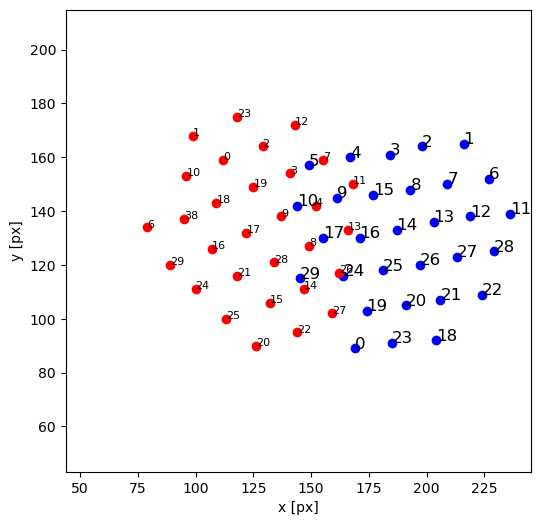

In [4]:
def trshow(tr, first_style='bo', last_style='ro', style='none'):
    frames = list(tr.groupby('frame'))
    nframes = len(frames)
    for i, (fnum, pts) in enumerate(frames):
        if i == 0:
            sty = first_style
            for pid, x, y in zip(pts['particle'], pts.x, pts.y):
                plt.annotate(pid, (x, y), fontsize=12)
        elif i == nframes - 1:
            sty = last_style
            for pid, x, y in zip(pts['particle'], pts.x, pts.y):
                plt.annotate(pid, (x, y), fontsize=8)
        else:
            sty = style
        plt.plot(pts.x, pts.y, sty)
    if 'particle' in tr.columns:
        for pid in tr.particle.unique():
            color = cm.viridis(np.linspace(0, 1, nframes))
            #plt.plot(tr.x[tr.particle == pid], 
                     #tr.y[tr.particle == pid], color=color)
            #color = cm.viridis(np.linspace(0, 1, nframes))
            tr_particle = tr[tr.particle == pid]
            #sc = plt.scatter(tr_particle.x, tr_particle.y, c=color[tr_particle.frame], cmap='viridis', s=5)
    #ylim(-11, 11)
    plt.xlabel('x [px]')
    plt.ylabel('y [px]')
#     plt.xlim(25,175)
#     plt.ylim(210,60) 
    #cbar = plt.colorbar(sc)
    #cbar.set_label('Time')

# Use the link_df function with the Linker object
tp.linking.Linker.MAX_SUB_NET_SIZE = num_rotor + 5
t = tp.link_df(features, search_range=25, memory=5)

# cap = cv2.VideoCapture('s_30mesogens_500rpm_500fps_10s_1.mp4')
# frame_number = 0
# cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
# ret, img = cap.read()
# img=img[350:-400, 425:-325] 

plt.figure(figsize=[6,6])
#tp.plot_traj(t)
#tp.plot_traj(t, superimpose=img)
plt.figure(figsize=[6,6])
trshow(t)
t.head()

In [9]:
print(t)
t_filtered = tp.filter_stubs(t, threshold=7499) # 7499
print(t_filtered)

          x    y  frame  particle
0       169   89      0         0
29      216  165      0         1
28      198  164      0         2
27      184  161      0         3
26      167  160      0         4
...     ...  ...    ...       ...
224955  144   95   7499        22
224954  126   90   7499        20
224982  143  172   7499        12
224967  122  132   7499        17
224983  118  175   7499        23

[224984 rows x 4 columns]
         x    y  frame  particle
frame                           
0      169   89      0         0
0      216  165      0         1
0      198  164      0         2
0      184  161      0         3
0      167  160      0         4
...    ...  ...    ...       ...
7499   144   95   7499        22
7499   126   90   7499        20
7499   143  172   7499        12
7499   122  132   7499        17
7499   118  175   7499        23

[223715 rows x 4 columns]


In [10]:
t_filtered.to_excel('f_30rotors_5wt_1.3T_5mm_high_50fps_0-150s.xlsx', index=False)

In [11]:
def fill_missing_particles(df):
    
    df = df.reset_index(drop=True)
    # Count the number of particles in each frame
    frame_counts = df.groupby('frame').particle.nunique()
    # Identify frames with fewer than 30 particles
    missing_frames = frame_counts[frame_counts < 30].index

    for frame in missing_frames:
        prev_frame, next_frame = frame - 1, frame + 1

        # Identify missing particles
        current_particles = set(df[df['frame'] == frame]['particle'])
        prev_particles = set(df[df['frame'] == prev_frame]['particle'])
        next_particles = set(df[df['frame'] == next_frame]['particle'])
        missing_particles = (prev_particles & next_particles) - current_particles

        for particle in missing_particles:
            # Calculate average position
            prev_pos = df[(df['frame'] == prev_frame) & (df['particle'] == particle)][['x', 'y']].values[0]
            next_pos = df[(df['frame'] == next_frame) & (df['particle'] == particle)][['x', 'y']].values[0]
            avg_pos = (prev_pos + next_pos) / 2

            print(f'Frame: {frame}, Particle: {particle}')
            print(f'Previous Position: {prev_pos}')
            print(f'Next Position: {next_pos}')
            print(f'Average Position: {avg_pos}')

            # Append the new row to the DataFrame
            new_row = pd.DataFrame({'frame': [frame], 'particle': [particle], 'x': [avg_pos[0]], 'y': [avg_pos[1]]})
            df = pd.concat([df, new_row], ignore_index=True)

    return df.sort_values(by=['frame', 'particle']).reset_index(drop=True)

# Apply the function to the DataFrame
filled_df = fill_missing_particles(t_filtered)
print(filled_df)

df:


,x,y,frame,particle
0,169,89,0,0
1,216,165,0,1
2,198,164,0,2
3,184,161,0,3
4,167,160,0,4
5,149,157,0,5
6,227,152,0,6
7,209,150,0,7
8,193,148,0,8
9,161,145,0,9


frame_counts:


frame
0    30
1    30
2    30
3    30
4    30
Name: particle, dtype: int64

Index([  61,   62,   84,   90,   91,   98,  106,  115,  171,  387,
       ...
       7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499],
      dtype='int64', name='frame', length=1284)
Missing frames: [61, 62, 84, 90, 91, 98, 106, 115, 171, 387, 388, 389, 4651, 4665, 4666, 4680, 4681, 4740, 5734, 5735, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 635

In [12]:
filled_df.to_excel('f_30rotors_5wt_1.3T_5mm_low_50fps_0-150s.xlsx', index=False)